# (CAM) ConvNet Attention Maps/Class Activation Maps

#### Written by Zenas Huang

Class Activation Maps, also sometimes known as Convolutional Attention Maps, are a common explainability technique for the inspection of visual image classifiers enabling users to understand what regions of an image that a neural net is focusing on for its' classification predictions. As an additional benefit, these attentional heatmaps are also often useful for the soft-localization of regions or objects of interest within images. In this tutorial, we will run through an example of how to extract class activation maps from a toy image classifier model and then explore an alternative approach utilizing the powerful captum library. While the method we apply here is using a toy dataset and a pre-trained resnet18 from the torchvision library, the basic principles of this approach are broadly applicable to any image encoder or classifier that is based on a convolutional neural net architecture. For more details, the original work detailing this method can be found at: http://cnnlocalization.csail.mit.edu/.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

import cv2
import captum

For setup, we will borrow the data setup and generic model code from the main pytorch tutorials webpage that uses a simple pre-trained resnet18 trained on imagenet for our classification predictions. For more details on where the below setup and training code derives from, see: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
<br>
The data for running this toy example can be downloaded at: https://download.pytorch.org/tutorial/hymenoptera_data.zip<br>
Please ensure that the data is downloaded and in the correct folder directory location visible to this tutorial notebook before continuing. 

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

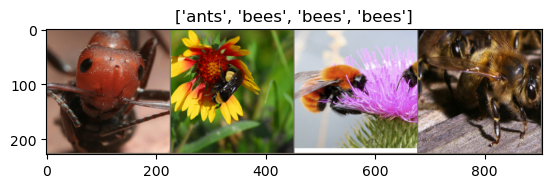

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#Define training loop for the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
#set training hyperparameters
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
#Fine-tune/train the model for the hymenoptera subset (takes ~ 22 minutes on CPU)
#number of epochs may vary, but generally should train the model to as high of a validation accuracy as possible
#in order to ensure good quality attention maps. For this example, 25 epochs is generally sufficient for ~90% acc.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7443 Acc: 0.6557
val Loss: 0.1915 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5086 Acc: 0.7664
val Loss: 0.5820 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.7216 Acc: 0.7213
val Loss: 0.4736 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.6532 Acc: 0.7623
val Loss: 0.5870 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4301 Acc: 0.8238
val Loss: 0.2455 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5405 Acc: 0.7869
val Loss: 0.4717 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5624 Acc: 0.7869
val Loss: 0.5528 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.4518 Acc: 0.8033
val Loss: 0.3042 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2719 Acc: 0.8934
val Loss: 0.2200 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2845 Acc: 0.8811
val Loss: 0.2200 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3597 Acc: 0.8607
val Loss: 0.2137 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3182 Acc: 0.8607
val Loss: 0.2016 Acc: 0.9477

Ep

This ends the portion of tutorial code from the pytorch main page that we need to setup a model. Subsequently, we will now work through the process of generating a CAM map for our simple two class classifier for the hymenoptera dataset (i.e. classifying images of bees vs. ants)

Now that we have a fine-tuned model, we can extract the class activations for each model prediction by defining a forward hook. The forward hook allows us to store all of the feature map activations that correspond to a class prediction when we run an image instance through the model's forward pass. These are then used to generate the Class Activation Map in a process called Global Average Pooling. Here we have elected to attach the forward hook to the fourth layer of the pre-trained ResNet so that the features_blobs list will collect all the activations outputted from that layer. In theory, one could attach the hook to any preceding layer, but usually this is not done as the features learned by ConvNets are hierarchical in nature and utilizing multiple activation hooks across layers could result in unwanted redundancy.

In [8]:
feature_blobs = []

def hook_feature(module, input, output):
    feature_blobs.append(output.data.cpu().numpy())

# Hook the layer right before the final fully connected layer
model_ft.layer4[1].register_forward_hook(hook_feature)

Now that we have setup the feature hook on a target layer for our model, we can begin by picking out a sample instance from our dataloader and run through the process of generating the model's attention heatmap for that image.

In [28]:
#***
#pick a sample instance on which to extract a CAM heatmap
dataiter = next(iter(dataloaders['val']))
image, label = dataiter
image = image[0].unsqueeze(0).to(device)
label = label[0].unsqueeze(0).to(device)

In [29]:
#run the instance through one forward pass of the model to obtain one prediction
output = model_ft(image)
_, pred = torch.max(output, 1)

In [30]:
#Extract the feature activations from feature_blobs
features = feature_blobs[0]

#retrieve weights of the final fully connected layer
params = list(model_ft.parameters())

#get softmax weights from the fully connected layer
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

In [31]:
#Compute the Class Activation Map for the predicted class of the instance
_, nc, h, w = features.shape
cam = weight_softmax[pred[0].cpu().numpy()].dot(features.reshape((nc, h*w)))

cam = cam.reshape(h, w)
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)

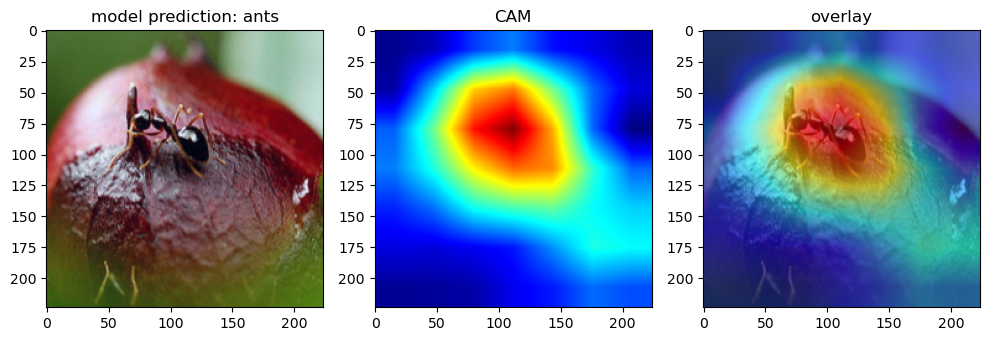

In [32]:
#do normalizations and visualize the cam

#Normalize the CAM to range [0, 1]
cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min())
#Convert the heatmap to RGB after resizing
heatmap = cv2.applyColorMap(np.uint8(255 * cv2.resize(cam_img, (image.size(3), image.size(2)))), cv2.COLORMAP_JET)
#Convert RGB heatmap to [0,1] 
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

img_np = image[0].cpu().numpy().transpose((1, 2, 0))
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

#Make a weighted sum of the heatmap and original image
alpha = 0.55
overlay = heatmap * alpha + img_np * (1 - alpha)
overlay = np.clip(overlay, 0, 1)

#display
fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].imshow(img_np)
axs[0].set_title(f'model prediction: {class_names[pred[0].item()]}')
axs[1].imshow(heatmap)
axs[1].set_title('CAM')
axs[2].imshow(overlay)
axs[2].set_title('overlay')
plt.tight_layout()
plt.show()

##### Interpretation: 

Here we see the heatmap for the given image input along with the Class Activation map and an overlay of the CAM on the original image that provides a convenient visualization of what our model is focusing on when it makes its decision to predict the given class. More red colored regions correspond to high importance regions while cooler, more blue regions correspond to areas which were less important for the model's prediction. 

### Alternative Method

Since the development of the CAM method in 2015, a number of packages have been released to streamline the process. Most notably, pytorch now comes with an entire suite of deep learning explainability methods for generating attentional maps like CAM within its' model explainability library Captum: https://pytorch.org/tutorials/recipes/recipes/Captum_Recipe.html?highlight=captum.
<br><br>
While captum allows for a number of different methods like CAM maps based on the occlusion method, the integrated gradients method, the layer-wise gradcam; we will just examine one alternative approach to making image classifier attention maps that leverages the LayerGradCam method from the captum library. In this approach, the region saliencies are computed as the gradients of a model's target layer upon passing a sample instance through the forward pass. This is in contrast to the original method of global average pooling we used above wherein we generate saliency heatmaps by using the softmax weights from the fully connected layer as class importance weightings upon each of the final convolution layer's collected feature maps. 

In [33]:
from captum.attr import LayerGradCam

In [34]:
#set model to evaluation mode
model_ft.eval();

In [35]:
#define layer to target
target_layer = model_ft.layer4[-1]

In [36]:
#Initialize layer GradCAM
lgc = LayerGradCam(model_ft, target_layer)

In [37]:
#Compute LayerGradCAM
lgc_attribution = lgc.attribute(image, target = label[0])

In [38]:
#normalize the atribution to visualize the result
lgc_attribution = torch.squeeze(lgc_attribution)
lgc_attribution = lgc_attribution.cpu().detach().numpy()
lgc_attribution = (lgc_attribution - lgc_attribution.min())/(lgc_attribution.max() - lgc_attribution.min())

In [39]:
#convert to heatmap
lgc_heatmap = cv2.applyColorMap(np.uint8(255 * lgc_attribution), cv2.COLORMAP_JET)
lgc_heatmap = cv2.cvtColor(lgc_heatmap, cv2.COLOR_BGR2RGB) / 255.0
#resize the heatmap to the input image size to make the overlay
lgc_heatmap = cv2.resize(lgc_heatmap, (img_np.shape[1], img_np.shape[0]))


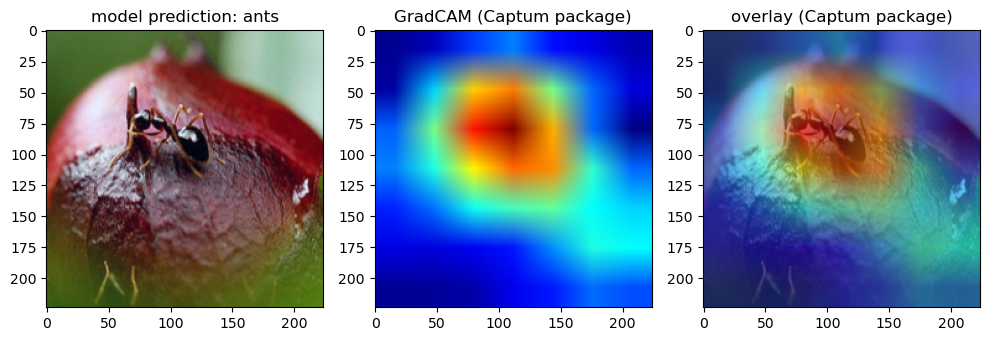

In [40]:
#make weighted sum of heatmap and original image
alpha = 0.55
lgc_overlay = lgc_heatmap *alpha + img_np * (1- alpha)
lgc_overlay = np.clip(lgc_overlay, 0, 1)

figc, axsc = plt.subplots(1,3, figsize=(10,10))
axsc[0].imshow(img_np)
axsc[0].set_title(f'model prediction: {class_names[pred[0].item()]}')
axsc[1].imshow(lgc_heatmap)
axsc[1].set_title('GradCAM (Captum package)')
axsc[2].imshow(lgc_overlay)
axsc[2].set_title('overlay (Captum package)')
plt.tight_layout()
plt.show();

Below we visualize both the captum implementation of GradCAM juxtaposed alongside our previous manual CAM method based on the global average pooling method. We observe that both methods provide similar attentional heatmaps and generally highlight the same regions. However, due to the nature of the GradCAM method's being a gradient based computation we also can observe that it's activated regions are less well-defined than the manual method which uses global average pooling. Depending on one's use case this can be a benefit or a disadvantage. 

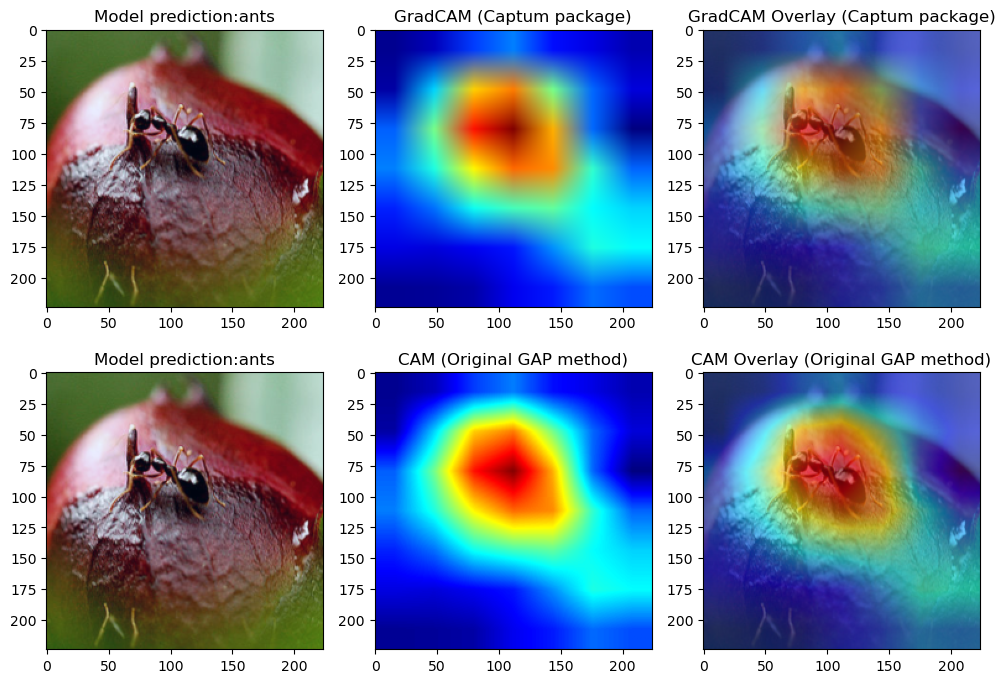

In [45]:
# Method Comparison 
figs, axes = plt.subplots(2,3, figsize=(10,7))
axes[0,0].imshow(img_np)
axes[0,0].set_title(f'Model prediction:{class_names[pred[0].item()]}')
axes[0,1].imshow(lgc_heatmap)
axes[0,1].set_title('GradCAM (Captum package)')
axes[0,2].imshow(lgc_overlay)
axes[0,2].set_title('GradCAM Overlay (Captum package)')
axes[1,0].imshow(img_np)
axes[1,0].set_title(f'Model prediction:{class_names[pred[0].item()]}')
axes[1,1].imshow(heatmap)
axes[1,1].set_title('CAM (Original GAP method)')
axes[1,2].imshow(overlay)
axes[1,2].set_title('CAM Overlay (Original GAP method)')
plt.tight_layout()
plt.show();

In [27]:
#To visualize for another instance, make sure to first run this cell to clear the feature maps being
#stored in the blobs list first and then return to the cell beginning with #*** and rerun from there.
feature_blobs.clear()

***Tutorial End***